# Fine Tuning

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras import layers, regularizers, initializers, optimizers
from tensorflow_addons.metrics import F1Score
from keras.utils import np_utils

import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

import time

In [2]:
def model_builder(hp):
    hp_a = hp.Choice('a', values=[0.1, 0.001, 0.000001])
    hp_lr = hp.Choice('lr', values=[0.1, 0.01, 0.001])

    # Set regularizer
    reg = keras.regularizers.L2(hp_a)

    # Weight initializer
    initial = keras.initializers.HeNormal()

    hp_hidden_1 = hp.Choice('hidden1', values=[64, 128])
    hp_hidden_2 = hp.Choice('hidden2', values=[256, 512])

    model = keras.models.Sequential([
        layers.Flatten(input_shape=(28*28,)),
        layers.Dense(hp_hidden_1, activation='relu', kernel_initializer=initial, kernel_regularizer=reg),
        layers.Dense(hp_hidden_2, activation='relu', kernel_initializer=initial, kernel_regularizer=reg),
        layers.Dense(10, kernel_initializer=initial, kernel_regularizer=reg)
    ])

    opt = optimizers.RMSprop(learning_rate=hp_lr)
    loss_func = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(loss=loss_func, metrics=['accuracy', F1Score(num_classes=10, average='macro')], optimizer=opt)

    return model

In [3]:
# MNIST dataset parameters
num_classes = 10 # total classes (0-9 digits)
num_features = 784 # data features (img shape: 28*28)
num_epochs = 1000 # no. epochs

# Preparation of MNIST data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

y_train = keras.utils.to_categorical(y_train)

In [4]:
# Initialize tuner
tuner = kt.Hyperband(model_builder, objective=kt.Objective('val_f1_score', direction='max'), max_epochs=num_epochs)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

st = time.time()

tuner.search(x_train, y_train, epochs=num_epochs, validation_split=0.2, callbacks=[early_stop])

end = time.time()

print('Hyperparametre search time:', end-st, 'seconds')

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print('The chosen optimal parameters are:')
print('Neurons in 1st hidden layer:', best_hps.get('hidden1'))
print('Neurons in 2nd hidden layer:', best_hps.get('hidden2'))
print('L2-regularization param:', best_hps.get('a'))
print('Learning rate:', best_hps.get('lr'))

Trial 35 Complete [00h 00m 29s]
val_f1_score: 0.018126705661416054

Best val_f1_score So Far: 0.9704495668411255
Total elapsed time: 00h 17m 42s
INFO:tensorflow:Oracle triggered exit
Hyperparametre search time: 1061.7139854431152 seconds
The chosen optimal parameters are:
Neurons in 1st hidden layer: 128
Neurons in 2nd hidden layer: 256
L2-regularization param: 1e-06
Learning rate: 0.001


Epoch 1/1000
188/188 [==============================] - 3s 11ms/step - loss: 0.3704 - accuracy: 0.8920 - f1_score: 0.8906 - val_loss: 0.2262 - val_accuracy: 0.9305 - val_f1_score: 0.9309
Epoch 2/1000
188/188 [==============================] - 2s 8ms/step - loss: 0.1629 - accuracy: 0.9512 - f1_score: 0.9507 - val_loss: 0.1531 - val_accuracy: 0.9531 - val_f1_score: 0.9525
Epoch 3/1000
188/188 [==============================] - 2s 8ms/step - loss: 0.1148 - accuracy: 0.9654 - f1_score: 0.9651 - val_loss: 0.1365 - val_accuracy: 0.9591 - val_f1_score: 0.9586
Epoch 4/1000
188/188 [==============================] - 2s 8ms/step - loss: 0.0863 - accuracy: 0.9747 - f1_score: 0.9746 - val_loss: 0.1001 - val_accuracy: 0.9694 - val_f1_score: 0.9691
Epoch 5/1000
188/188 [==============================] - 2s 8ms/step - loss: 0.0680 - accuracy: 0.9795 - f1_score: 0.9794 - val_loss: 0.1064 - val_accuracy: 0.9682 - val_f1_score: 0.9679
Epoch 6/1000
188/188 [==============================] - 2s 8ms/step -

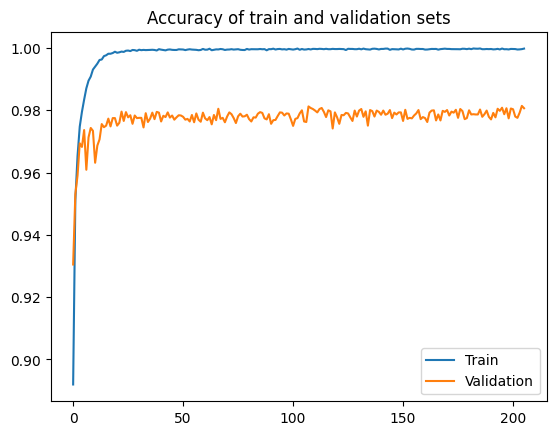

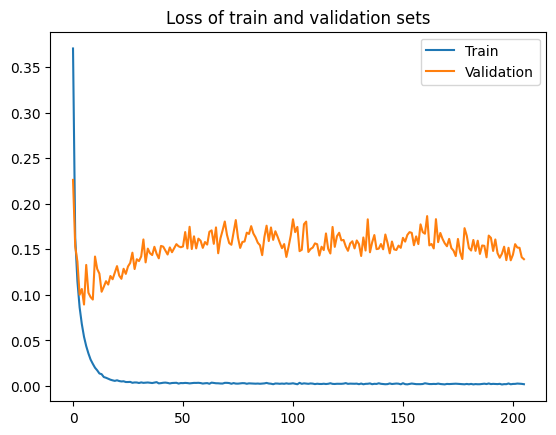

In [5]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(x_train, y_train, batch_size=256, epochs=num_epochs, validation_split=0.2, callbacks=[early_stop])

val_acc = history.history['val_accuracy']
best_epoch = val_acc.index(max(val_acc))
print('The epoch chosen for early stopping would be:', best_epoch)

plt.figure()
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.legend()
plt.title('Accuracy of train and validation sets')

plt.figure()
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.title('Loss of train and validation sets')

plt.show()

Confusion matrix

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.98      0.97      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.97      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.98      0.98       974
           9       0.97      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



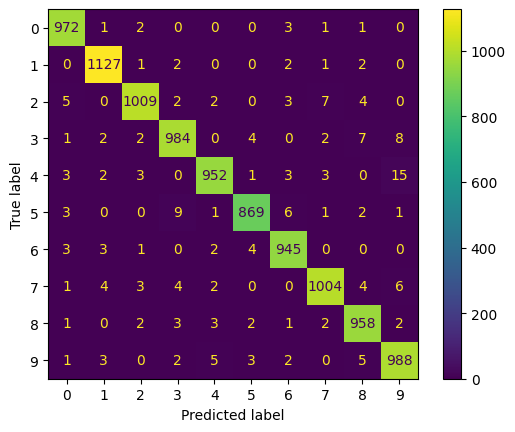

In [6]:
# Predict the output of the test set
y_prob = model.predict(x_test)
y_pred = y_prob.argmax(axis=1)

# Show the accuracy, recall, precision and f-measure
print(classification_report(y_test, y_pred))

# Create the confusion matrix
labels = np.arange(10)

cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()